In [3015]:
import csv
import codecs
import urllib.request
from collections import Counter
import glob
import codecs
import re
import pandas as pd
import math
from cmath import exp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from pylab import rcParams
from matplotlib.pyplot import *
from numpy.linalg import inv
from statsmodels.tsa.seasonal import seasonal_decompose
# sns.reset_orig()
np.random.seed(0)
sns.set_theme(context='notebook')

<h3>1. Linear and Logistic Regression. (15 points)
A. Optimization Routines and Loss Functions
1. In this part of the assignment we learn how to write modular programs and make our code reusable.
For this, declare a class named Optimization which has 2 inputs X and y as the class variables. Next,
implement the following four optimization algorithms in this class.
a) Stochastic Gradient Descent
b) Newton’s method

In [3016]:
def accuracy(a,b):
    return sum(1 for x,y in zip(a,b) if x == y) / len(a)

In [3017]:
def RMSE(y,y_pred):
        return np.sqrt(np.mean(np.square(np.subtract(y,y_pred))))

In [3018]:
def score(y,y_hat):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(y)):
        if y[i] == 1 and y_hat[i] == 1:
            tp = tp + 1
        elif y[i] == 1 and y_hat[i] == 0:
            fn = fn + 1
        elif y[i] == 0 and y_hat[i] == 1:
            fp = fp + 1
        elif y[i] == 0 and y_hat[i] == 0:
            tn = tn + 1
    tp = 1 #to avoid inf condition
    fp = 1 #to avoid inf condition
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    return np.round(f1, 4), np.round(precision, 4), np.round(recall, 4)

<h3>You will need loss functions and their gradients for the optimization process. Next, implement a class
Loss which also takes in X and y and computes the following losses and their gradients.
a) Mean Square Loss
b) Cross Entropy Loss
Make the Loss class such that you can access it from the Optimization class.

<h1>1. Linear and Logistic Regression.

<h2> Find below part 1 and 2 for Question 1 part A

In [3019]:
class Loss:
    def __init__(self, y, y_pred):
        self.y = y
        self.y_pred = y_pred

    def crossEntropyLoss(self, y,y_pred):
        a = y*np.log(y_pred)
        b = (1-y)*np.log(1-y_pred)
        return -np.sum(a+b)

    def meanSquaredError(self, y,y_pred): # Mean Squared Error
        MSE = np.mean(np.square(np.subtract(y,y_pred))) # manually computing MSE
        return MSE

<h3>In this part of the assignment we learn how to write modular programs and make our code reusable.
For this, declare a class named Optimization which has 2 inputs X and y as the class variables. Next,
implement the following four optimization algorithms in this class.
a) Stochastic Gradient Descent
b) Newton’s method

In [3020]:
class Optimization:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def newton(self):
        y = self.y
        x = self.X
        loss_obj = Loss(x,y) # creating object for loss class here
        learning_rate = 0.01
        iters = 2000
        costList = []
        y = y.to_numpy()
        y.shape = (len(y),1)
        x.insert(0, 'ones', 1)
        x = x.to_numpy()
        _, cols = np.shape(x)
        beta_initial = np.zeros(cols)
        beta_initial.shape = (len(beta_initial), 1)
        
        for i in range(iters):
            y_pred = self.predict(x, beta_initial)
            grad = -1 * np.dot(x.T, (y-y_pred))
            hadamard = np.squeeze(np.asarray(np.multiply(y_pred, (1-y_pred))))
            diag = np.diag(hadamard) 

            hessian = np.dot(x.T, np.dot(diag, x))
            hessianInv = np.linalg.inv(hessian)
            beta_new = beta_initial - learning_rate * np.dot(hessianInv, grad)
            oldLoss = loss_obj.crossEntropyLoss(y, y_pred) # calling MSE method to compute cost
            newLoss = loss_obj.crossEntropyLoss(y, self.predict(x, beta_new)) # calling MSE method to compute cost
            diff = oldLoss - newLoss
            costList.append(newLoss)

            if  np.abs(diff)  < 1e-6:
                print('Stopping Condition Reached')
                break
            else:
                beta_initial = beta_new
        return beta_new, costList


    def sgd(self, X, y, alpha= 0.01, epochs=1000, batchsize=50):
        m, n = X.shape
        theta = np.zeros((n,1))
        costList = []
        loss_obj = Loss(X,y) #creating loss obj here
        costList.append(999999) # appending large value in cost list

        for epoch in range(epochs):
            idxList = np.random.randint(0, m, size = batchsize)
            batch = np.take(X, idxList, axis=0)
            y_batch = np.take(y, idxList, axis=0)
            y_batch.shape = (batchsize, 1)

            for i in range(len(batch)):
                hypothesis = np.dot(batch, theta) # generating prediction
                loss = hypothesis-y_batch # computing error
                gradient = np.dot(batch.T, loss)/len(batch) # computing gradient
                theta = theta - alpha*gradient # updating theta
                
            cost = loss_obj.meanSquaredError(y, np.dot(X,theta)) # calling MSE method to compute cost
            costList.append(cost)
            # print('epoch {} and cost {}'.format(epoch, cost))
            if np.abs(costList[epoch] - costList[epoch+1]) < 1e-6:
                    print('Stopping Condition Reached')
                    break
        return theta, costList

    def predict(self, x, beta):
        z = np.dot(x,beta)
        y_pred = 1/(1+np.exp(-z))
        y_pred.shape = (len(y_pred),1)
        return y_pred

In [3021]:
class LinearRegression:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.betas = None

    def fit(self):
        opt = Optimization(self.X, self.y) #create object for optimization class
        betas, costList = opt.sgd(self.X, self.y) #in optimization a method called newton is available which can be called this way
        return betas, costList

    def predict(self, x, beta): # predicting
        return np.dot(x,beta)

In [3022]:
class LogisticRegression:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.betas = 0

    def fit(self):
        opt = Optimization(self.X, self.y) #create object for optimization class
        betas, costList = opt.newton() #in optimization a method called newton is available which can be called this way
        return betas, costList

    def predict(self, x, beta):
        y_pred = 1/(1+np.exp(-np.dot(x,beta)))
        y_pred.shape = (len(y_pred),1)
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        return y_pred

<h3> Logistic Regression
You are given a file logistic.csv. This part of the assignment involves a classification task. Implement a class
LogisticRegression having at least two functions, fit, predict for fitting the model and getting the predictions.
Fit a logistic regression model with the following pair:
1. Cross Entropy Loss and Newton’s Method.
Report the test accuracy, plot the confusion matrix and also compute the precision, recall and F-score. Read
about these parameters. Suppose model A and model B both have same accuracy, but model B has a higher
F-score, which model would be suited? In the end, generate the loss trajectory for both training and testing.

<span style="color:blue"> The model which has higher F score is more suitable</span>.

<h1>Logistic Regression

In [3023]:
import pandas as pd
df = pd.read_csv("logistic.csv")
df['Y'].replace(['M', 'B'],[1, 0], inplace=True)
df.dropna(True)
shuffled = df.sample(frac=1, random_state=13232).reset_index(drop=True)
trainLen = int(0.8 * len(shuffled))
train = shuffled[:trainLen]
test = shuffled[trainLen:]

train.head()
y_train = train['Y']
y_test = test['Y']
x_train = train.loc[:, train.columns != 'Y']
x_test = test.loc[:, test.columns != 'Y']
x_test.insert(0, 'ones', 1)
logistic_xtest = x_test
logistic_ytest = y_test

x_train=(x_train-x_train.mean())/x_train.std()

logistic_xtrain = x_train
logistic_ytrain = y_train

In [3024]:
obj = LogisticRegression(logistic_xtrain, logistic_ytrain) #create an object of Logistic Regression
betas, costList = obj.fit() #calling this method to fit the model
logistic_pred = obj.predict(logistic_xtest, betas) #this method predicts and returns the predictions
print('Optimized weights are: \n', betas)

Optimized weights are: 
 [[  17.47406433]
 [-593.52130574]
 [  -6.32116795]
 [ 483.50975924]
 [ 244.26079376]
 [  -4.43723351]
 [ -22.36066025]
 [ -28.45380178]
 [  60.52198998]
 [ -17.85886381]
 [   7.40936377]
 [ 165.05719775]
 [ -20.52546317]
 [  12.43183945]
 [-120.87077434]
 [  -0.77288833]
 [ -33.049528  ]
 [ -43.47979079]
 [  54.26153983]
 [ -36.76003145]
 [   1.80384786]
 [-201.79292222]
 [  44.28817511]
 [ 126.78828772]
 [  80.4838354 ]
 [   6.62212934]
 [ -93.416178  ]
 [ 130.44933695]
 [ -18.91254119]
 [  48.10040585]
 [  22.24112419]]


In [3025]:
acc = accuracy(logistic_pred, logistic_ytest)
print('Accuracy for Logistic Regression is: ', np.round(acc*100,2))

Accuracy for Logistic Regression is:  39.47


In [3026]:
logistic_ytest = logistic_ytest.to_numpy()

In [3027]:
# score(logistic_ytest.to_numpy(), logistic_pred)

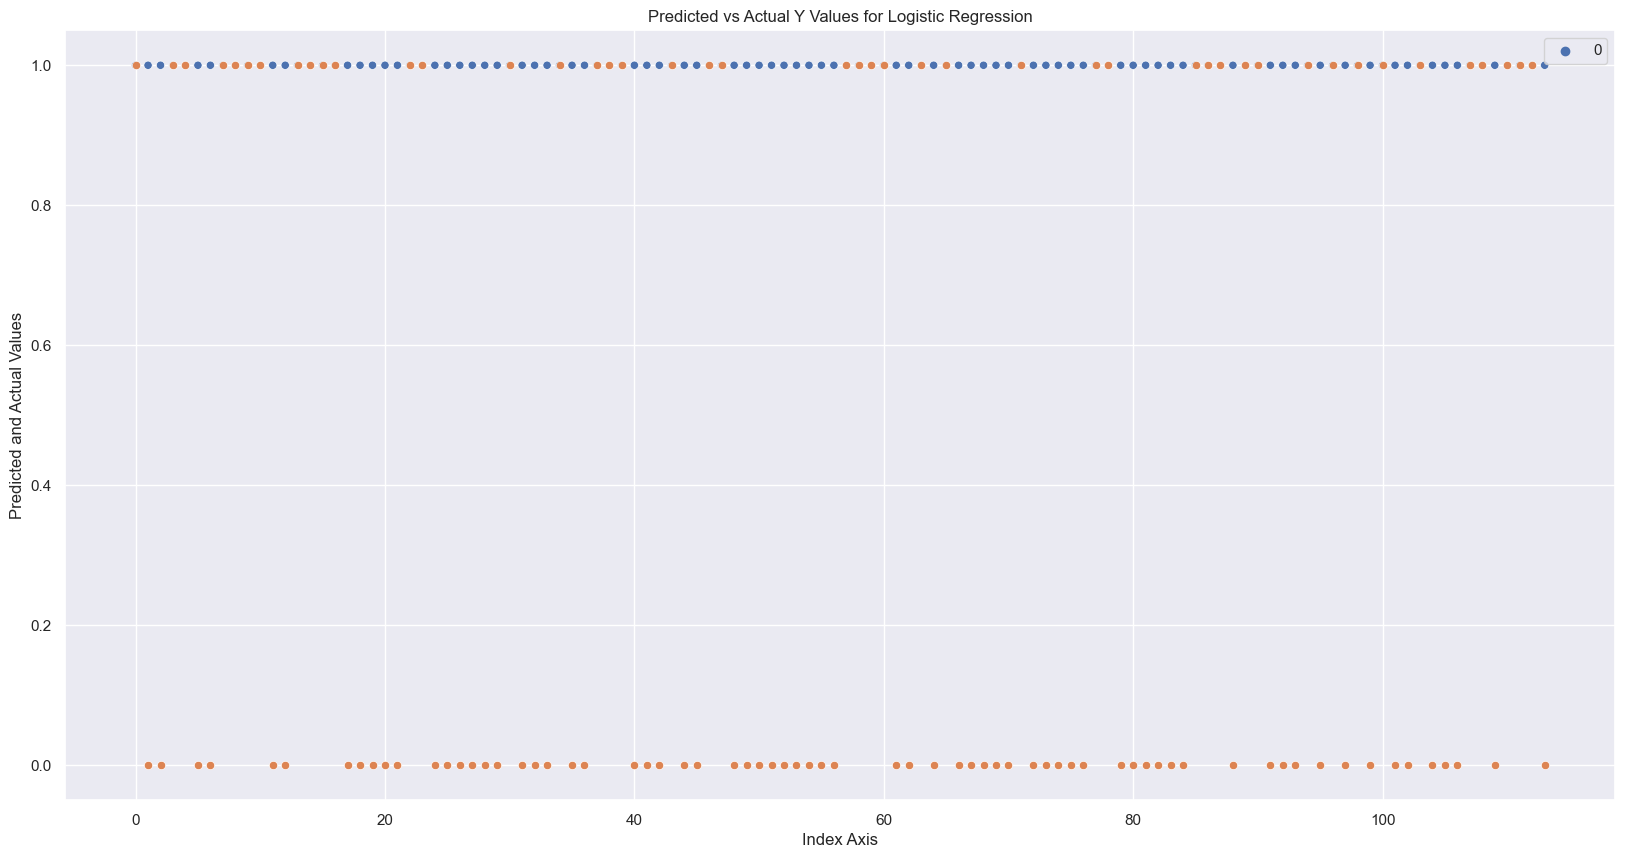

In [3028]:
plt.figure(figsize=(20,10))
sns.scatterplot(logistic_pred)
sns.scatterplot(logistic_ytest)
plt.xlabel('Index Axis')
plt.ylabel('Predicted and Actual Values')
plt.title('Predicted vs Actual Y Values for Logistic Regression')
plt.show()

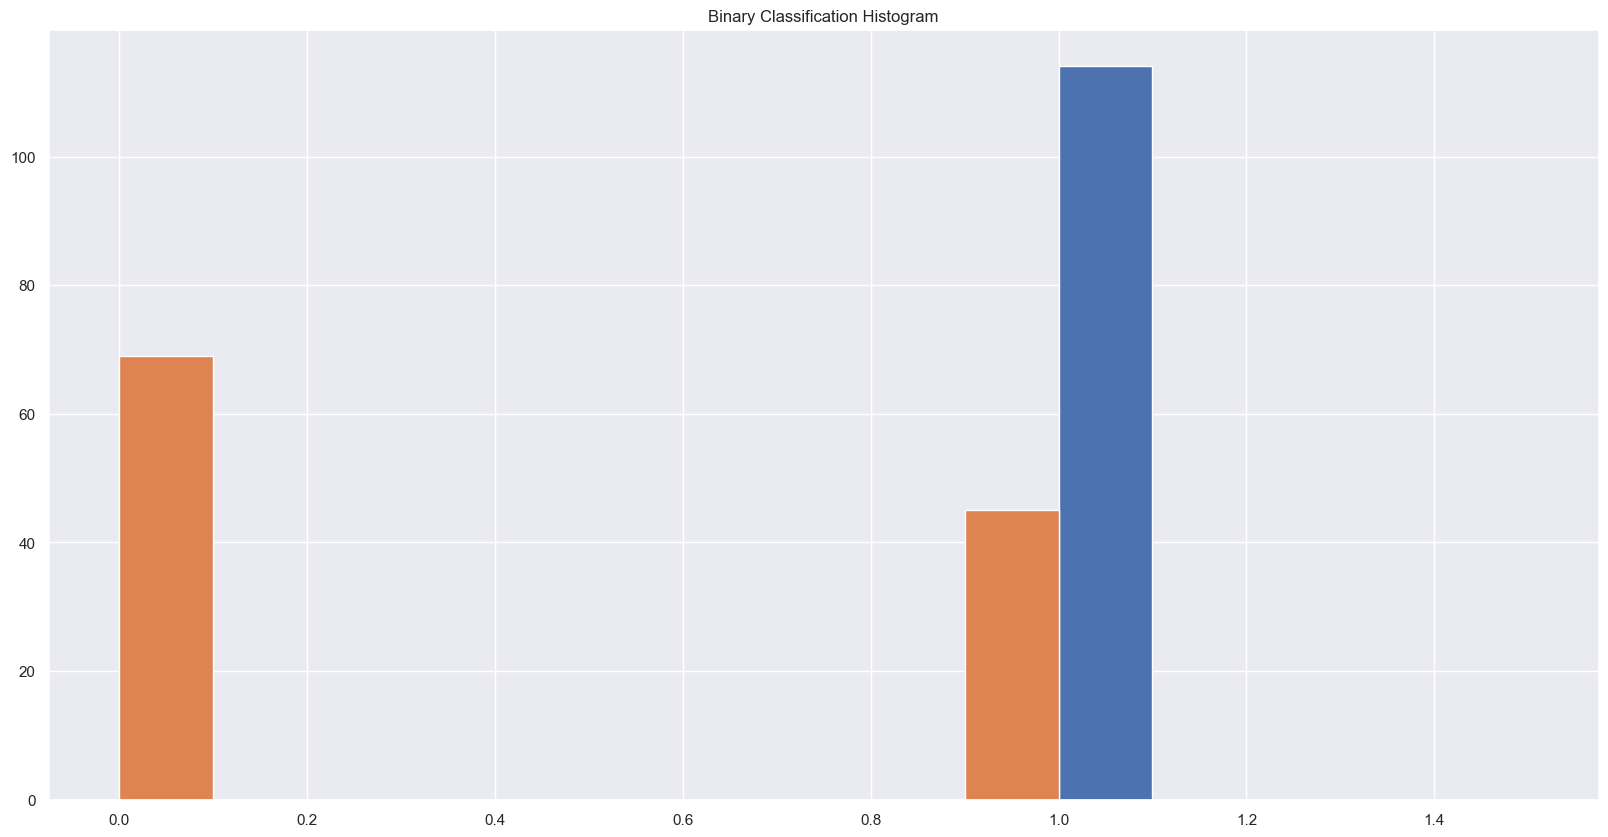

In [3029]:
plt.figure(figsize=(20,10))
plt.hist(logistic_pred)
plt.hist(logistic_ytest)
plt.title('Binary Classification Histogram')
plt.show()

<Figure size 2000x1000 with 0 Axes>

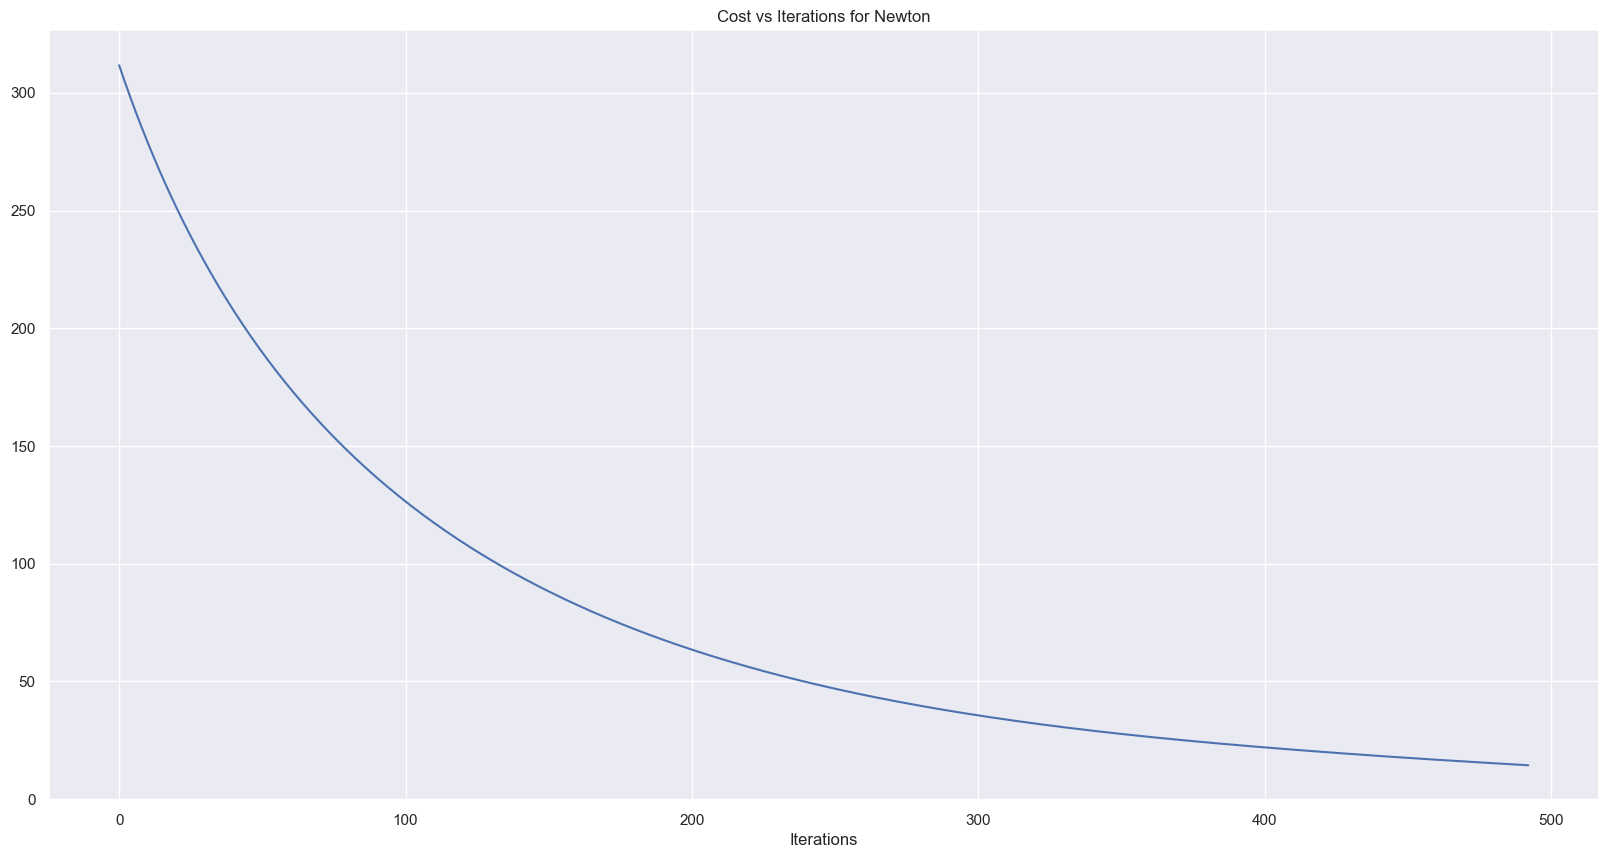

In [3030]:
plt.figure(figsize=(20,10))
plt.figure(figsize=(20,10))
sns.lineplot(costList)
plt.xlabel('Iterations')
plt.title('Cost vs Iterations for Newton')
plt.show()

<h3>B. Linear Regression
In this task, you are given a data set named regression.csv. Implement a class LinearRegression that has at
least two functions, fit , predict for fitting a linear regression model and predicting the results. You need to use
the Optimization and Loss class inside this. Fit a linear regression model with the following pair:
1. Mean Square Loss and Stochastic Gradient Descent.
In the end, generate the loss trajectory for both training and testing.
While optimising the loss function for Linear Regression or Logistic Regression, one needs to initialise the model
parameters. It is well known that deep neural networks do not function if the model parameters are initialised to
zero. Why is it so? Does this issue also arise while optimising the loss function for Linear or Logistic Regression?
Explain.

<span style="color:blue"> If the neural weights are initialized from 0, the derivative will remain same with respect to the loss function for all the weights. This means all weights will have same values in all the iterations, essentially there will be no updation of values. The hidden layers become symmetric, which essentially means that the network is just equivalent to a Linear Model. Setting biases to 0 won't be a problem but weights to 0 introduce symmetry, and the model cannot learn complicated models. </span>.

<h1> Linear Regression

In [3031]:
import pandas as pd
df = pd.read_csv("regression.csv")

#normalizing the data
df=(df-df.min())/(df.max()-df.min())


# Separating train and test sets
trainLen = int(0.8 * len(df))
train = df[:trainLen]
test = df[trainLen:]
y_train = train['Y']
y_test = test['Y']
x_train = train.loc[:, train.columns != 'Y']
x_test = test.loc[:, test.columns != 'Y']
x_test.insert(0, 'ones', 1)

linear_xtest = x_test
linear_ytest = y_test

x = x_train.to_numpy()
y = y_train.to_numpy()

#adding a ones column in X
n = np.max(x.shape)
x = np.vstack([np.ones(n), x.T]).T      

linear_xtrain = x
linear_ytrain = y

In [3032]:
obj = LinearRegression(linear_xtrain, linear_ytrain) #create LinearRegression object
betas, costList = obj.fit() #calling method to fit the model
linear_predict = obj.predict(linear_xtest, betas) #this method predicts and returns the predictions
print('Optimized weights are: \n', betas)

Stopping Condition Reached
Optimized weights are: 
 [[ 0.29228126]
 [ 0.10369099]
 [-0.00163649]
 [ 0.10286289]
 [ 0.01869838]
 [ 0.01046457]
 [ 0.02248623]
 [-0.0218188 ]
 [ 0.06629423]
 [ 0.11871548]
 [ 0.10017658]
 [ 0.21253196]]


In [3033]:
rmse = RMSE(list(linear_ytest), list(linear_predict))
print('RMSE for SGD Linear Regression is: ', np.round(rmse, 2))

RMSE for SGD Linear Regression is:  0.16


In [3034]:
f1, prec, recall = score(linear_predict, linear_ytest.to_numpy())
print('F1 Score: ', f1)
print('Precision is: ', prec)
print('Recall is: ', recall)

F1 Score:  0.6667
Precision is:  0.5
Recall is:  1.0


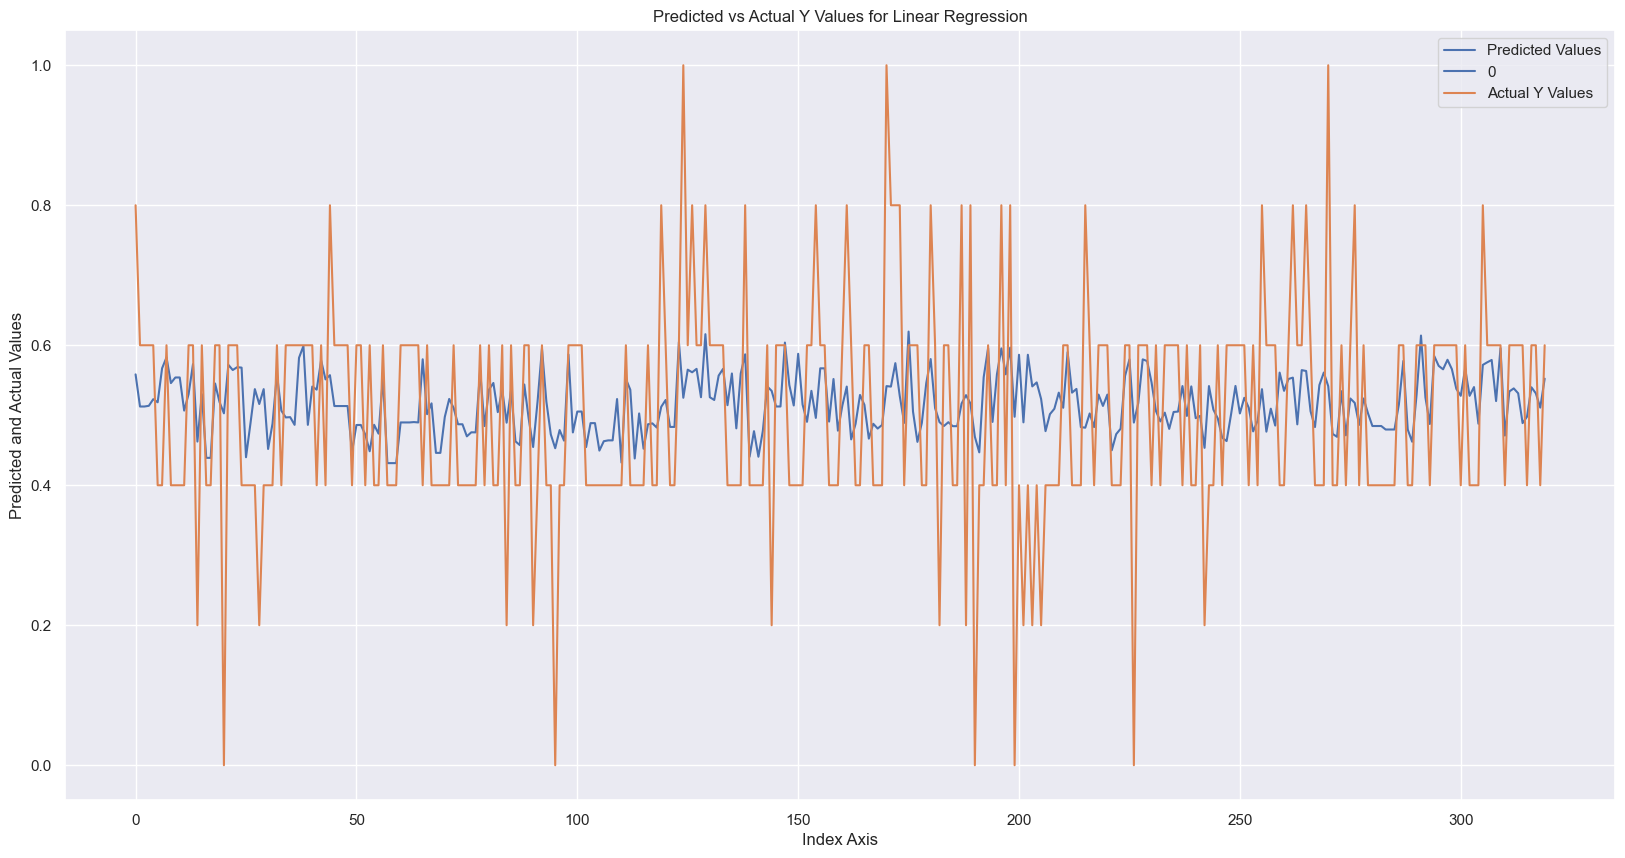

In [3035]:
plt.figure(figsize=(20,10))
sns.lineplot(linear_predict, label = 'Predicted Values')
sns.lineplot(linear_ytest.to_numpy(), label = 'Actual Y Values')
plt.xlabel('Index Axis')
plt.ylabel('Predicted and Actual Values')
plt.title('Predicted vs Actual Y Values for Linear Regression')
plt.show()

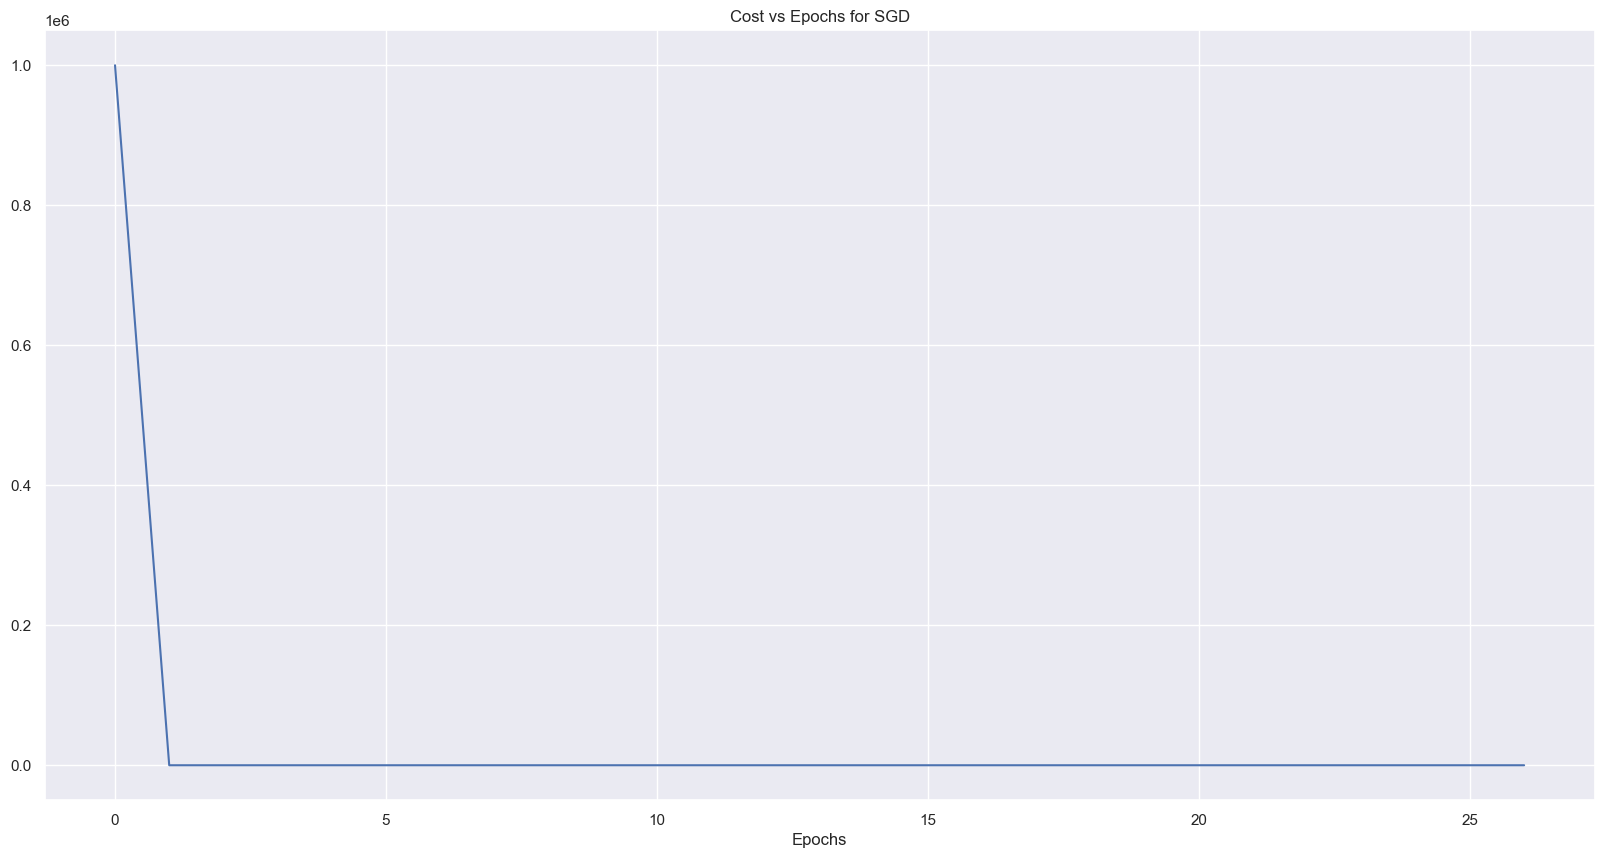

In [3036]:
plt.figure(figsize=(20,10))
sns.lineplot(costList)
plt.xlabel('Epochs')
plt.title('Cost vs Epochs for SGD')
plt.show()

<h1>2. Discriminant Analysis

<h3>In this part of the assignment you will implement linear and quadratic discriminant analysis classifiers on the
iris dataset from scratch. Again, this should follow an object oriented method of implementation where you
need 2 classes LDA() and QDA() with the associated fit() and predict() methods. Read this dataset using
data = load iris() command from the sklearn library. Report the test accuracies for both LDA and QDA.

In [3037]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
iris = load_iris()
ii = iris
X = iris.data 
Y = iris.target
xtrain = X[:100]
ytrain = Y[:100]

xtest = X[100:150]
ytest = Y[100:150]

<h1>LDA

In [3038]:
class LDA:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y


        self.classes = set(Y)
        self.pi_k = np.zeros(len(Y))
        self.covMats = None
        self.means = None
        self.CommonCovariance = None

    def fit(self):
        X = self.X
        Y = self.Y
        self.pi_k = []
        self.means = []
        covMats = []
        _, n = X.shape
        commonCov = np.zeros((n,n))

        for i in self.classes:
            getX = X[Y == i]
            pik = getX.shape[0]/X.shape[0]
            self.pi_k.append(pik)
            getmean = np.mean(getX, axis=0)
            self.means.append(getmean)
            corrected = getX-self.means[i]
            covMats.append(np.dot(corrected.T,corrected))
            commonCov+= (0.5)*covMats[i] 
        self.CommonCovariance = commonCov

    def predict(self, test):
        parentPredicts = []
        m, _ = test.shape
        for i in range(m):
            sample = test[i]
            distList = []
            for i in self.classes:
                mux = self.means[i]
                xmux = sample-mux
                MD = np.dot(xmux, np.dot(np.linalg.inv(self.CommonCovariance), xmux.T ))
                disf = -0.5 * np.log(np.linalg.det(self.CommonCovariance)) - 0.5 * MD + np.log(self.pi_k)
                distList.append(disf)
            predicted = np.argmax(distList)
            parentPredicts.append(predicted)
        return parentPredicts

In [3039]:
o = LDA(xtrain,ytrain)
o.fit()
predictions = o.predict(xtest)
print(predictions)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [3040]:
print('Accuracy for LDA is: ', accuracy(ytest, predictions)*100)

Accuracy for LDA is:  100.0


<h1>QDA

In [3041]:
class QDA:
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.classes = np.unique(Y)
        self.pi_k = np.zeros(len(Y))
        self.covMats = None
        self.means = None
        self.covMatsList = None

    def fit(self):
        X = self.X
        Y = self.Y
        pi_k = []
        self.means = []
        covMats = []
        for c in self.classes:
            getX = X[Y == c]
            pi_k.append(getX.shape[0] / X.shape[0])
            getmean = np.mean(getX, axis=0)
            self.means.append(getmean)
            corrected = getX-self.means[c]
            covMats.append((1/3)*np.dot(corrected.T,corrected))
        self.covMatsList = covMats

    def predict(self, test):
        parentPredicts = []
        m, _ = test.shape
        for i in range(m):
            sample = test[i]
            distList = []
            for i in self.classes:
                mux = self.means[i]
                xmux = sample-mux
                MD = np.dot(xmux, np.dot(np.linalg.inv(self.covMatsList[i]), xmux.T ))
                disf = -0.5 * np.log(np.linalg.det(self.covMatsList[i])) - 0.5 * MD + np.log(1/2)
                distList.append(disf)
            predicted = np.argmax(distList)
            parentPredicts.append(predicted)
        return parentPredicts

In [3042]:
o = QDA(xtrain,ytrain)
o.fit()
predictions = o.predict(xtest)
print(predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [3043]:
print('Accuracy for QDA is: ', accuracy(ytest, predictions)*100)

Accuracy for QDA is:  0.0
